# Downloading & Loading the Dataset

In [ ]:
# !pip install -q kaggle
# ! mkdir ~/content/drive/My Drive/Colab Notebooks/MMAI 894
# ! cp kaggle.json ~/content/drive/My Drive/Colab Notebooks/MMAI 894/
# ! chmod 600 ~/kaggle/kaggle.json

In [ ]:
# from google.colab import drive
# drive.mount('/gdrive')

In [ ]:
# #Set the directory to where you want to have your dataset & jason authentication file
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Colab Notebooks/MMAI 894/Dataset"
# %cd /content/drive/My Drive/Colab Notebooks/MMAI 894/Dataset/

In [ ]:
# from kaggle.api.kaggle_api_extended import KaggleApi
# import zipfile

In [ ]:
# # this will prompt you to upload the kaggle.json
# from google.colab import files

# files.upload() 

In [ ]:
# # Check if your jason file is there and authentication is successful
# api = KaggleApi()
# api.authenticate()
# !ls -lha kaggle.json

Uncomment this section only to unzip the files agian. Otherwise, the bad quality image won't run. Change remove_bad_quality to True only if you uncomment the unzip cell.

In [ ]:
# # ! kaggle competitions download google-smartphone-decimeter-challenge
# !kaggle datasets download -d cookiefinder/tomato-disease-multiple-sources
# with zipfile.ZipFile('tomato-disease-multiple-sources.zip', 'r') as zip_ref:
#         zip_ref.extractall('./')

# Loading Modules and Importing Dataset

In [ ]:
import os
import cv2
import time
import shutil
import itertools
import glob

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')

import matplotlib.pyplot as plt
import matplotlib.image as img

from sklearn.metrics import confusion_matrix, classification_report

from skimage.io import imread
from skimage.transform import resize
import random

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

import zipfile
from google.colab import drive
from PIL import ImageFile

import PIL
import PIL.Image

from pathlib import Path
import imghdr

import tqdm, re, json

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, layers
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
print ('modules loaded')

modules loaded


In [ ]:
# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Set the directory to your specific folder in Google Drive
folder_path = "/content/drive/My Drive/Colab Notebooks/MMAI 894/Dataset/"

# Check if the directory exists and print the list of files and folders inside it
if os.path.exists(folder_path):
    files = os.listdir(folder_path)
    print(files)
else:
    print("Directory does not exist.")

root_dir = "/content/drive/My Drive/" 
# choose where you want your project files to be saved
project_folder = "Colab Notebooks/MMAI 894/Dataset/"
os.chdir(root_dir + project_folder)

Mounted at /content/drive
['tomato-disease-multiple-sources.zip', 'train', 'valid']


In [ ]:
!pwd

/content/drive/My Drive/Colab Notebooks/MMAI 894/Dataset


# Read Datasets from Drive Datasets

In [ ]:
main_dir = os.getcwd()
train_dir = os.path.join(main_dir, 'train')
val_dir = os.path.join(main_dir, 'valid')

https://www.tensorflow.org/tutorials/load_data/images

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=os.listdir(train_dir),
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=24,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    )

Found 25821 files belonging to 11 classes.


In [ ]:
Original_val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=24,
    validation_split=0.5,
    subset='both',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    )

Found 6677 files belonging to 11 classes.
Using 3339 files for training.
Using 3338 files for validation.


In [ ]:
val_ds = Original_val_ds[0]
test_ds = Original_val_ds[1]

In [ ]:
train_ds_save = train_ds
val_ds_save = val_ds
test_ds_save = test_ds

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32, 11)


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot', 'Spider_mites Two-spotted_spider_mite', 'Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_mosaic_virus', 'healthy', 'powdery_mildew']


# Delete Bad Quality Images

In [ ]:
remove_bad_quality = False # Only need to run the first time

In [ ]:
train_len, test_len = 0, 0
for f in os.listdir(train_dir):
  train_len += len(os.listdir(os.path.join(train_dir, f)))
  test_len += len(os.listdir(os.path.join(val_dir, f)))
print(train_len);print(test_len)

25821
6677


In [ ]:
def image_quality_check(image_dir):
  '''
  This functions checks whether file formats accepted by Tensorflow ( JPEG, PNG, GIF, BMP), or may be corrupted.
  '''
  from pathlib import Path
  import imghdr

  image_extensions = ['.jpg', '.png', '.jpeg', '.PNG', '.JPG', '.JPEG']
  img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
  bad_images = []

  for filepath in Path(image_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            bad_images.append(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            bad_images.append(filepath)
  return bad_images

In [ ]:
def image_quality_check2(image_dir):
  '''
  This function captures corrupted image files (jpg and png) that may missed by first QA function.
  '''
  import os, glob

  # validate directory
  assert os.path.exists(image_dir), "Error: directory does not exist"

  bad_images = []
  classes = sorted([c for c in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, c))])

  def is_valid_jpg(jpg_file):
    with open(jpg_file, 'rb') as f:
      f.seek(-2,2)
      buf = f.read()
      return buf == b'\xff\xd9'

  def is_valid_png(png_file):
    with open(png_file, 'rb') as f:
      f.seek(-2,2)
      but = f.read()
      return but == b'\x60\x82'

  for f_class in classes:
    class_path = os.path.join(image_dir, f_class)
    file_list = os.listdir(class_path)
    desc = f'{f_class:23s}'
    for file in tqdm.tqdm(file_list, ncols=110, desc=desc, unit='file', colour='blue'):
      fpath = os.path.join(class_path, file)
      index = file.rfind('.')
      if file[index:] in ['.jpg', '.jpeg','.JPG', '.JPEG']:
        if not is_valid_jpg(fpath):
          print(fpath)
          bad_images.append(fpath)
      
      if file[index:] in ['.png', '.PNG']:
        if not is_valid_png(fpath):
          print(fpath)
          bad_images.append(fpath)

  return bad_images

In [ ]:
def image_quality_check3(image_dir):
  '''
  This function focuses on identifying corrupted png images that may be missed by the QA1 and QA2.
  '''
  assert os.path.exists(image_dir), "Error: directory does not exist"

  bad_images = []
  classes = sorted([c for c in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, c))])

  for f_class in classes:
    class_path = os.path.join(image_dir, f_class)
    file_list = os.listdir(class_path)
    desc = f'{f_class:23s}'
    for file in tqdm.tqdm(file_list, ncols=110, desc=desc, unit='file', colour='blue'):
      fpath = os.path.join(class_path, file)
      index = file.rfind('.')
      if file[index:] in ['.png', '.PNG']:
        try:
          image = tf.io.read_file(fpath)
          image = tf.image.decode_png(image, channels=3)
        except:
          bad_images.append(fpath)
          print('defective image file: ', fpath)
  return bad_images

In [ ]:
if remove_bad_quality:
  # check image quality
  %time
  print("-"*20, "check training set image quality.","-"*20)
  bad_images_train = image_quality_check(train_dir)
  print("-"*20, "check test and validation set image quality.","-"*20)
  bad_images_val_test = image_quality_check(val_dir)


In [ ]:
if remove_bad_quality:
  # check image quality 2
  %time
  print("-"*20, "check training set image quality.","-"*20)
  bad_images_train2 = image_quality_check2(train_dir)
  print("-"*20, "check test and validation set image quality.","-"*20)
  bad_images_val_test2 = image_quality_check2(val_dir)

In [ ]:
if remove_bad_quality:
  # check image quality 3
  %time
  print("-"*20, "check training set image quality.","-"*20)
  bad_images_train3 = image_quality_check3(train_dir)
  print("-"*20, "check test and validation set image quality.","-"*20)
  bad_images_val_test3 = image_quality_check3(val_dir)

In [ ]:
if remove_bad_quality:
  bad_images = set(bad_images_train + bad_images_val_test + bad_images_train2 + bad_images_val_test2 + bad_images_train3 + bad_images_val_test3)
  bad_images
  for link in bad_images:
    if os.path.exists(link):
      os.remove(str(link))
  print('Move {} images with bad quality.'.format(len(bad_images)))



In [ ]:
train_len, test_len = 0, 0
for f in os.listdir(train_dir):
  train_len += len(os.listdir(os.path.join(train_dir, f)))
  test_len += len(os.listdir(os.path.join(val_dir, f)))
print(train_len);print(test_len)

25821
6677


# Create Clean Datasets

In [ ]:
if remove_bad_quality:
  train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=os.listdir(train_dir),
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=24,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    )

In [ ]:
if remove_bad_quality:
  Original_val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=24,
    validation_split=0.5,
    subset='both',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    )

In [ ]:
val_ds = Original_val_ds[0]
test_ds = Original_val_ds[1]

In [ ]:
print('train dataset size: ' + str(train_ds.cardinality().numpy()))
print('valid dataset size: ' + str(val_ds.cardinality().numpy()))
print('test dataset size: ' + str(test_ds.cardinality().numpy()))

train dataset size: 807
valid dataset size: 105
test dataset size: 105


In [ ]:
def plot_training(hist):
  '''
  This function plots training history. (ie training loss vs validation loss)
  '''
  tr_acc = hist.history['accuracy']
  tr_loss = hist.history['loss']
  val_acc = hist.history['val_accuracy']
  val_loss = hist.history['val_loss']
  index_loss = np.argmin(val_loss)
  val_lowest = val_loss[index_loss]
  index_acc = np.argmax(val_acc)
  acc_highest = val_acc[index_acc]

  plt.figure(figsize= (20, 8))
  plt.style.use('fivethirtyeight')
  Epochs = [i+1 for i in range(len(tr_acc))]
  loss_label = f'best epoch= {str(index_loss + 1)}'
  acc_label = f'best epoch= {str(index_acc + 1)}'

  plt.subplot(1, 2, 1)
  plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
  plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
  plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
  plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
  plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.tight_layout
  plt.show()

# Transfer Learning With MobileNetV2

In [ ]:
params = {
          'RANDOM_STATE': 24,
          'TRAINABLE': False,
          'DENSE_ACTIVATION':'relu',
          'DROPOUT_RATE':0.5,
          'LEARNING_RATE': 1e-4,
          'LEARNING_RATE_DECAY':False,
          'CHECKPOINT':True,
          'EPOCHS':50,
          'NUM_CLASSES': len(class_names),
}

In [ ]:
# early stopping 
early_stopping = EarlyStopping(
    monitor='val_loss', 
    mode='min',
    restore_best_weights=True,
    patience=7, 
    verbose=1
)

# check point - save best model
check_point = ModelCheckpoint(filepath='../model/mobilenet_best_1.hdf5',
                                          monitor='val_loss',
                                          mode='min',
                                          save_best_only=True
                                          )


# learning rate schedule
lr_start = 0.01

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr_start, params['EPOCHS'])
lr_scheduler = LearningRateScheduler(exponential_decay_fn)
     

callbacks = [early_stopping]

if params['CHECKPOINT']:
  callbacks.append(check_point)
if params['LEARNING_RATE_DECAY']:
  callbacks.append(lr_scheduler)

callbacks

In [ ]:
IMAGE_SIZE = (224,224)

In [ ]:
mobilenet = MobileNetV2(input_shape=IMAGE_SIZE+(3,), weights='imagenet', include_top=False)
for layer in mobilenet.layers:
    layer.trainable = False

In [ ]:
for layer in mobilenet.layers:
  if "BatchNormalization" in layer.__class__.__name__:
      layer.trainable = True

In [ ]:
x_mobilenet = mobilenet.output

x_mobilenet = layers.Dense(1024, activation=params['DENSE_ACTIVATION'])(x_mobilenet)
x_mobilenet = layers.Dropout(rate=params['DROPOUT_RATE'])(x_mobilenet)

# Add a GlobalAveragePooling2D layer to reduce the spatial dimensions of the tensor
x_mobilenet = layers.GlobalAveragePooling2D()(x_mobilenet)

prediction = keras.layers.Dense(len(class_names), activation='softmax')(x_mobilenet)

mobilenet_model = Model(inputs=mobilenet.input, outputs=prediction)


In [ ]:
mobilenet_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=params['LEARNING_RATE']) 
# loss = keras.losses.categorical_crossentropy(from_logits=False)

mobilenet_model.compile(optimizer=optimizer,
              loss=categorical_crossentropy,
              metrics=["accuracy"]
              )

In [ ]:
history = mobilenet_model.fit(train_ds, validation_data = val_ds, batch_size=128, epochs = params['EPOCHS'], callbacks = callbacks)

Epoch 1/50
807/807 [==============================] - 140s 152ms/step - loss: 0.8709 - accuracy: 0.7157 - val_loss: 1.0688 - val_accuracy: 0.6217
Epoch 2/50
807/807 [==============================] - 123s 151ms/step - loss: 0.4919 - accuracy: 0.8354 - val_loss: 0.5514 - val_accuracy: 0.8077
Epoch 3/50
807/807 [==============================] - 122s 151ms/step - loss: 0.3964 - accuracy: 0.8658 - val_loss: 0.3747 - val_accuracy: 0.8742
Epoch 4/50
807/807 [==============================] - 124s 153ms/step - loss: 0.3288 - accuracy: 0.8883 - val_loss: 0.3137 - val_accuracy: 0.8994
Epoch 5/50
807/807 [==============================] - 123s 152ms/step - loss: 0.2782 - accuracy: 0.9073 - val_loss: 0.2742 - val_accuracy: 0.9108
Epoch 6/50
807/807 [==============================] - 124s 153ms/step - loss: 0.2422 - accuracy: 0.9198 - val_loss: 0.2604 - val_accuracy: 0.9152
Epoch 7/50
807/807 [==============================] - 122s 151ms/step - loss: 0.2074 - accuracy: 0.9316 - val_loss: 0.2349 -

In [ ]:
test_loss, test_accuracy = mobilenet_model.evaluate(test_ds)

print("test loss: {} and test accuracy: {}".format(test_loss, test_accuracy))

105/105 [==============================] - 6s 58ms/step - loss: 0.1145 - accuracy: 0.9730
test loss: 0.11445256322622299 and test accuracy: 0.9730377197265625


In [ ]:
mobilenet_model.save('/content/drive/My Drive/Colab Notebooks/MMAI 894/MobilenetV2.h5')

In [ ]:
mobilenet_model = load_model('/content/drive/My Drive/Colab Notebooks/MMAI 894/MobilenetV2.h5')

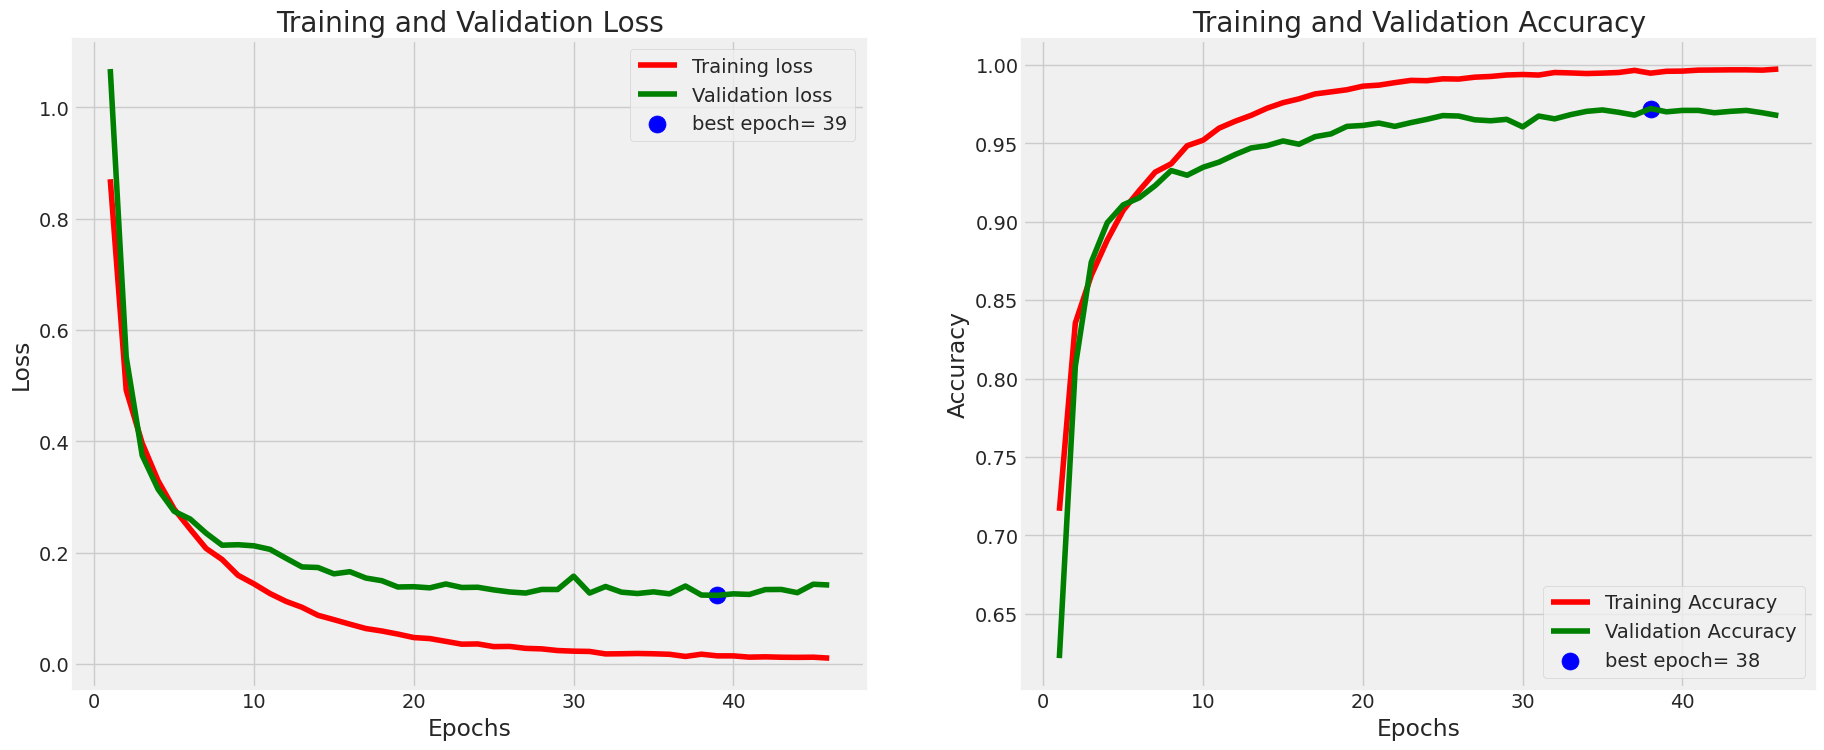

In [ ]:
plot_training(history)

In [ ]:
test_labels = []
for _, label in test_ds.map(lambda x, y: (x, y)):
    test_labels.append(label.numpy())

105/105 [==============================] - 7s 59ms/step
                                      precision    recall  f1-score   support

                      Bacterial_spot       0.98      0.97      0.98       367
                        Early_blight       0.94      0.93      0.93       316
                         Late_blight       0.96      0.97      0.97       389
                           Leaf_Mold       0.97      0.98      0.98       370
                  Septoria_leaf_spot       0.97      0.96      0.96       359
Spider_mites Two-spotted_spider_mite       0.98      0.99      0.98       224
                         Target_Spot       0.97      0.95      0.96       237
       Tomato_Yellow_Leaf_Curl_Virus       0.99      0.99      0.99       254
                 Tomato_mosaic_virus       0.98      0.98      0.98       313
                             healthy       0.98      0.99      0.99       388
                      powdery_mildew       0.98      0.99      0.98       121

      

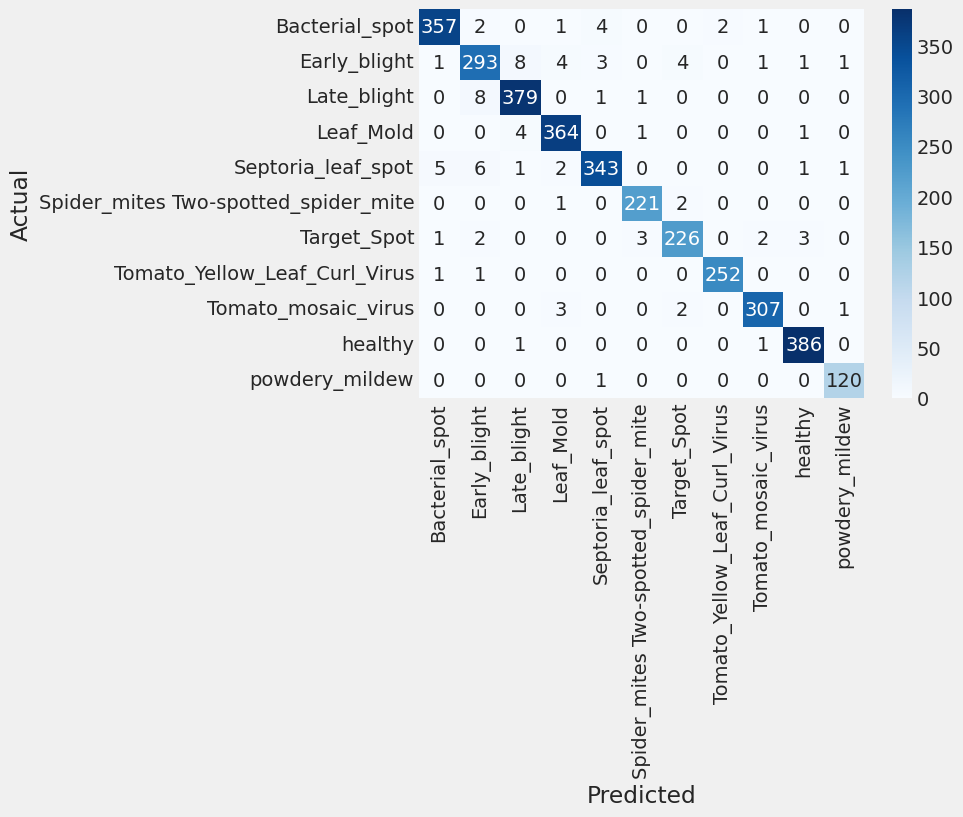

In [ ]:
from keras.utils import to_categorical
# convert labels to numerical format
test_labels = np.concatenate([y for x, y in test_ds])
test_labels = np.argmax(test_labels, axis=1)

# predict on test dataset
y_pred_mobilenet = mobilenet_model.predict(test_ds)

# convert predictions to class labels
y_pred_mobilenet = np.argmax(y_pred_mobilenet, axis=1)

# print classification report
print(classification_report(test_labels, y_pred_mobilenet, target_names=class_names))

# create confusion matrix
cm = confusion_matrix(test_labels, y_pred_mobilenet)

# plot confusion matrix using heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()